<div align='center'><font size='6'>CS304_Project2</font></div>

<div align='center'>Yuchen Song, Yiwei Liang</div>

# 1. Record Audio

In [1]:
import keyboard
import time
import wave
import pyaudio
import numpy as np
import IPython.display as ipd
frames=[]
#Define hit-to-talk function and set 's' as the start key
def hit_to_talk():
    keyboard.wait('s')
    time.sleep(2)
    print("Please talk")

#Define the function to calculate the energy of samples in decibel
def EnergyPerSampleInDecibel(audioframe):
    audioframe=np.frombuffer(np.array(audioframe),np.int16)
    np_audioframe=np.array(audioframe,dtype='int64')
    energy= 10*np.log10(np.sum(np.square(np_audioframe)))
    return energy

#Define the function to calculate the initial backgorund energy 
def find_ini_background(audioframe):
    background_energy=0
    background_energy+=EnergyPerSampleInDecibel(audioframe)
    return background_energy/10

#Define the calssifyFrame function to find the endpointing
def classifyFrame(audioframe,background,level, First_run):
    forgetfactor=2
    isSpeech=False
    current = EnergyPerSampleInDecibel(audioframe)
    if First_run:
        First_run=False
        level=EnergyPerSampleInDecibel(audioframe)
    else:
        level=((level*forgetfactor)+current)/(1+forgetfactor)
    threshold=10
    adjustment=0.05
    # print('Background',background,'current',current, 'level', level)
    if current < background:
        background = current
    else:
        background+=(current - background)*adjustment
    if (level < background): level = background
    # print(level-background)
    if (level - background > threshold): isSpeech = True
    return background,level,isSpeech

def record(frames):
    #parameters for recording
    CHUNK = 1600
    resolution = pyaudio.paInt16
    CHANNELS = 1
    sampling_rate = 16000
    stop_record_time=2
    stop_speak_time=0
    stop_speak_per_loop=0.1
    isSpeech=False
    p=pyaudio.PyAudio()
    stream = p.open(format=resolution, channels=CHANNELS, rate=sampling_rate, input=True, frames_per_buffer=CHUNK)
    
    level=0
    First_run=True
    frames_to_store=[]
    inspeech=False
    background=0
    First_inspeech=0
    
    while True:
        #If it is the first run, read the data of 10 chunks to calculate the average energy of these 10 chunks and set it as the initial value of background
        if First_run:
            audioframe=stream.read(CHUNK*10)
            background=find_ini_background(audioframe)
            First_run=False
        #Otherwise, read the data of 1 chunk to calculate energy in the classifyFrame function
        else: 
            audioframe=stream.read(CHUNK)
        #Save the data of each chunk in the list 'frames'
            
            background,level,isSpeech=classifyFrame(audioframe,background,level,First_run)
        # print(isSpeech)
        if isSpeech:
            if First_inspeech==0:
                First_inspeech=1
                frames_to_store=[]
            if frames_to_store!=[] and First_inspeech==1:
                for frame in frames_to_store:
                    frames.append(frame)
                    frames_to_store=[]
            frames.append(audioframe)
            stop_speak_time=0
        #level,isSpeech=classifyFrame(audioframe,background,level,First_run)
        #After the first iteration set First_run as False
        else: 
            if stop_speak_time<stop_record_time:
                frames_to_store.append(audioframe)
            stop_speak_time+=0.1
                
        
        #if the duration for which the energy remains below the threshold is too long, stop recording
        if stop_speak_time>=stop_record_time:
            #Save the speech to a wav file
            wf = wave.open('1.wav', 'wb')
            wf.setnchannels(CHANNELS)
            wf.setsampwidth(p.get_sample_size(pyaudio.paInt16))
            wf.setframerate(sampling_rate)
            wf.writeframes(b''.join(frames))
            wf.close()
            print("Audio data saved as 1.wav")
            stream.stop_stream()
            stream.close()
            p.terminate()
            break
    
def start():
    hit_to_talk()
    record(frames)
    

In [18]:
a=start()

Please talk
Audio data saved as 1.wav


# 2. Functions for getting Log Mel spectrum and Mel cepstrum

## Get 20ms segments

In [45]:
import matplotlib.pyplot as plt
# Divide signal data into 20ms segements with 10ms interval for every two consecutive ones 
def create_segments(signal,sample_rate,width=10):
    num=int(width*sample_rate/1000)
    # first divide signal into 10ms segments
    ten_ms_segments = [signal[i:i+num] for i in range(0, len(signal), num)]
    twenty_ms_segments =[]
    for j in range(len(ten_ms_segments)):
        if j!=0:
            l1=ten_ms_segments[j-1]
            l2=ten_ms_segments[j]
            l=[0 for i in range(num*2)]
            for k in range(len(l1)):
                l[k]=l1[k]
                l[k+len(l1)]=l2[k]
            twenty_ms_segments.append(l)
    return twenty_ms_segments

## Preemphasizing the segmented signal

In [59]:
# Preemphasize each segement
def Preemphasizing(segment):
    pre=np.zeros(len(segment))
    pre[0]=segment[0]
    for i in range(1,len(segment)):
        pre[i]=segment[i]-0.95*segment[i-1]
    return pre

## Windowing

In [47]:
# Window each preemphasized segement
def windowing(pre):
    pre=pre*np.hamming(len(pre))
    return pre

## Zero-padding

In [61]:
# Zero pad each windowed segement
def zero_padding(windowed):
    #zero padding for FFT
    length=512
    windowed_len=len(windowed)
    padding_len=length-windowed_len
    zeros=np.zeros((padding_len,))
    zero_padded=np.concatenate((windowed,zeros))
    return zero_padded

## FFT

In [63]:
# Calculate the power spectrum of a segement
def FFT(frame):
    length=512
    fft=np.fft.rfft(frame, length)
    magnitude = np.abs(fft)
    power = ((1.0 / length) * ((magnitude) ** 2)) 
    return magnitude

## Mel warping function and its inverse function

In [69]:
# Mel warping function
def warping_function(Hz):
    Mel = 2595 * np.log10(1+Hz/700)
    return Mel
# inverse function
def inverse_warping(Mel):
    Hz = 700*(np.power(10,Mel/2595)-1) 
    return Hz

## Get Mel spectrum and Log Mel spectrum

In [73]:
# calculate mel spectra and log mel spectra
def filterbanks(power,filter_num,minHz=133.33,maxHz=6855.4976,length=512):
    maxMel=warping_function(maxHz)
    minMel=warping_function(minHz)
    #get 40 triangle filters 
    pointsInMel=np.linspace(minMel,maxMel,filter_num+2)
    pointsInHz=inverse_warping(pointsInMel)
    ranges=np.floor((length + 1)/2*pointsInHz/(maxHz-minHz))
    #normalize the filters according to the lower bound
    ranges=ranges-ranges[0]
    points_in_f=int(np.floor(length/2+1))
    filter_banks=np.zeros((filter_num,points_in_f))
    for i in range(1,filter_num+1): 
        for j in range(int(ranges[i-1]),int(ranges[i])):
            filter_banks[i-1,j]=(j-ranges[i-1])/(ranges[i]-ranges[i-1])
        for j in range(int(ranges[i]),int(ranges[i+1])):
            filter_banks[i-1,j]=(ranges[i+1]-j)/(ranges[i+1]-ranges[i])
    #mel spectrum
    filter_banks=filter_banks.T
    Mel=np.dot(power,filter_banks)
    #log mel spectrum
    Log_Mel=10*np.log(Mel) 
    return Mel,Log_Mel

## Get Mel cepstrum

In [66]:
from scipy.fftpack import dct
# use dct to get the cepstral_coefficients
def mel_cepstrum(log_mel):
    cepstral_coefficients=dct(log_mel,axis=-1, type=2, norm='ortho')
    return cepstral_coefficients[:13]

# 3. Other Functions

In [67]:
# get log mel spectrum matrix and mel cpestrum matrix, given segments
def get_two_matrix(segments,num=40):
    Mel_cepstrum_matrix=[]
    log_Mel_spectrum_matrix=[]
    for i in range(len(segments)):
        preemphasized=Preemphasizing(segments[i])
        windowed=windowing(preemphasized)
        zero_padded=zero_padding(windowed)
        power_spectrum=FFT(zero_padded)
        Mel_spectrum, log_Mel_spectrum=filterbanks(power_spectrum,num)
        log_Mel_spectrum_matrix.append(log_Mel_spectrum)
        Mel_cepstrum=mel_cepstrum(log_Mel_spectrum)
        Mel_cepstrum_matrix.append(Mel_cepstrum)
    return log_Mel_spectrum_matrix,Mel_cepstrum_matrix
#plot the spectrum and cepstrum
def plot_show(log_mel_spectrum_matrix_T, title):
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 4))
        cax = ax.matshow(log_mel_spectrum_matrix_T.astype("float32"),interpolation="nearest",aspect="auto",cmap=plt.cm.jet,origin="lower")
        fig.colorbar(cax)
        plt.title(title)
        plt.show()

# 4. Main

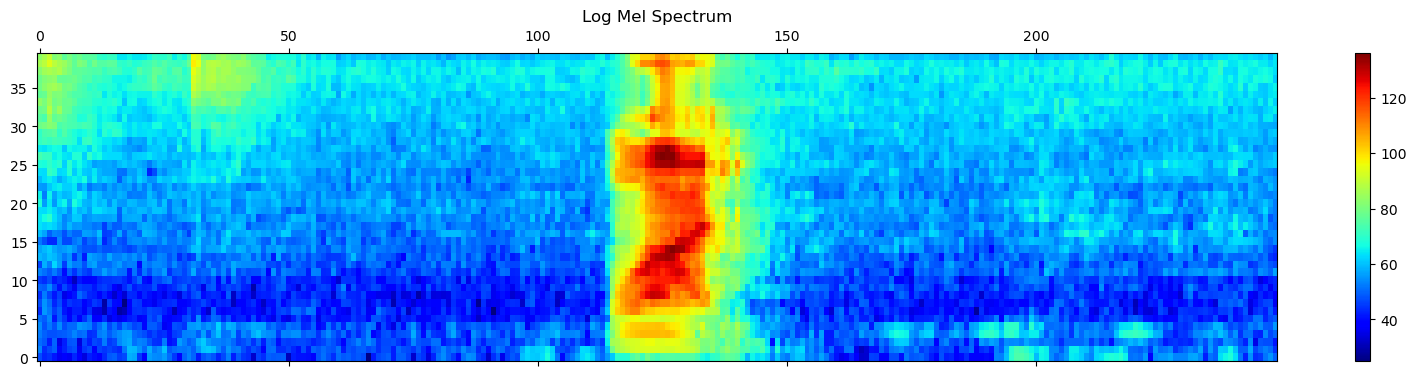

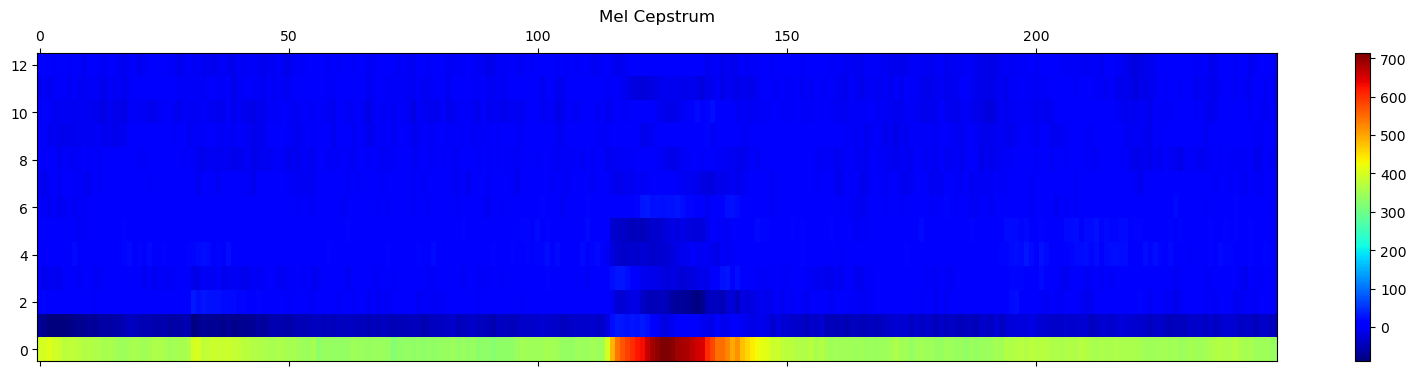

In [74]:
# Load the WAV file
file_path = '1.wav'
wav_file = wave.open(file_path, 'r')

# Get the audio data
frames = wav_file.readframes(-1)
signal = np.frombuffer(frames, dtype=np.int16)

# Get the sample rate and time axis
sample_rate = wav_file.getframerate()
duration = len(signal) / sample_rate
time = np.linspace(0., duration, len(signal))

# Close the WAV file
wav_file.close()

# Get segments from signal
seg=create_segments(signal,sample_rate)

# Get two matrix from segments
log_mel_spectrum_matrix,mel_cepstrum_matrix=get_two_matrix(seg,40)
log_mel_spectrum_matrix,mel_cepstrum_matrix=np.array(log_mel_spectrum_matrix),np.array(mel_cepstrum_matrix)

# Plot Log Mel spectrum and Mel cepstrum
plot_show(log_mel_spectrum_matrix.T,'Log Mel Spectrum')
plot_show(mel_cepstrum_matrix.T, 'Mel Cepstrum')

# 5. Modify number of filters to 30 and 25

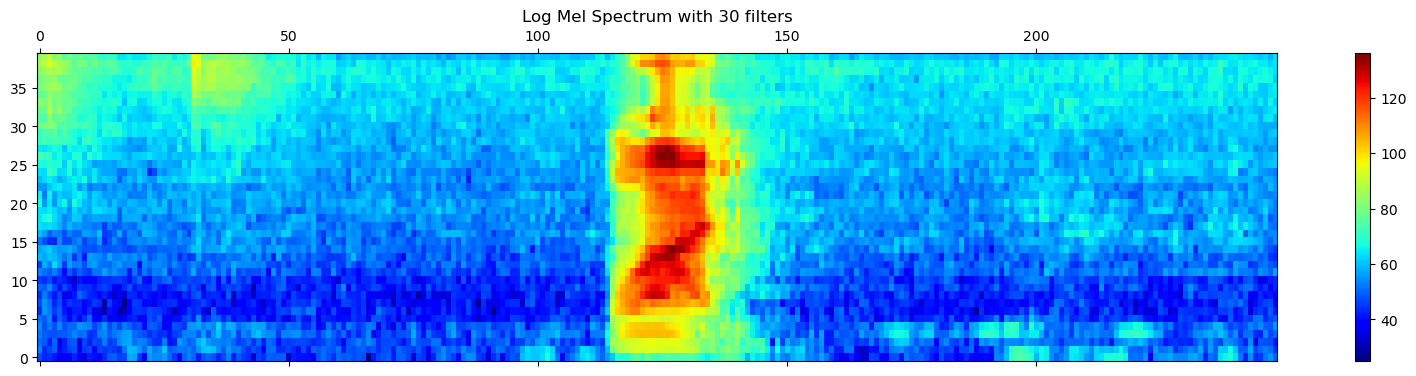

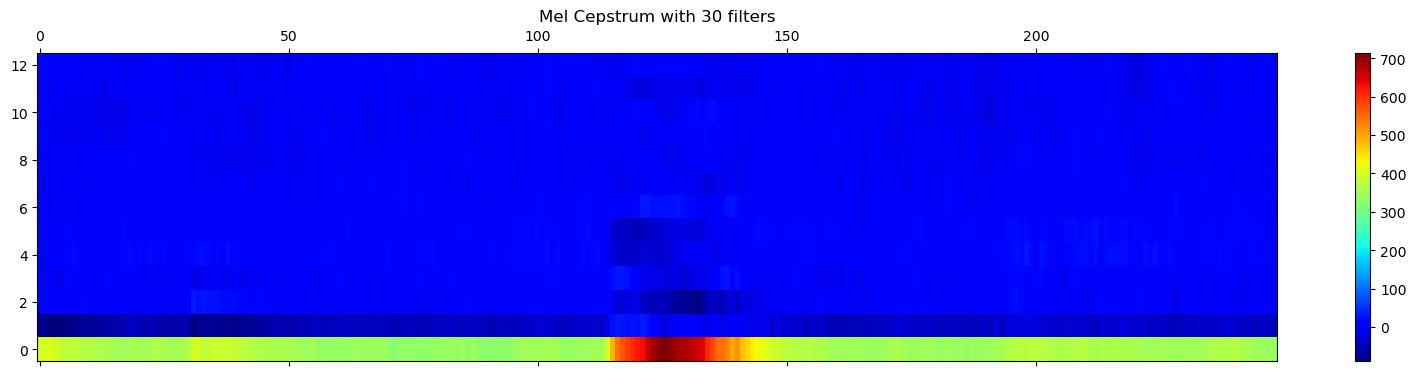

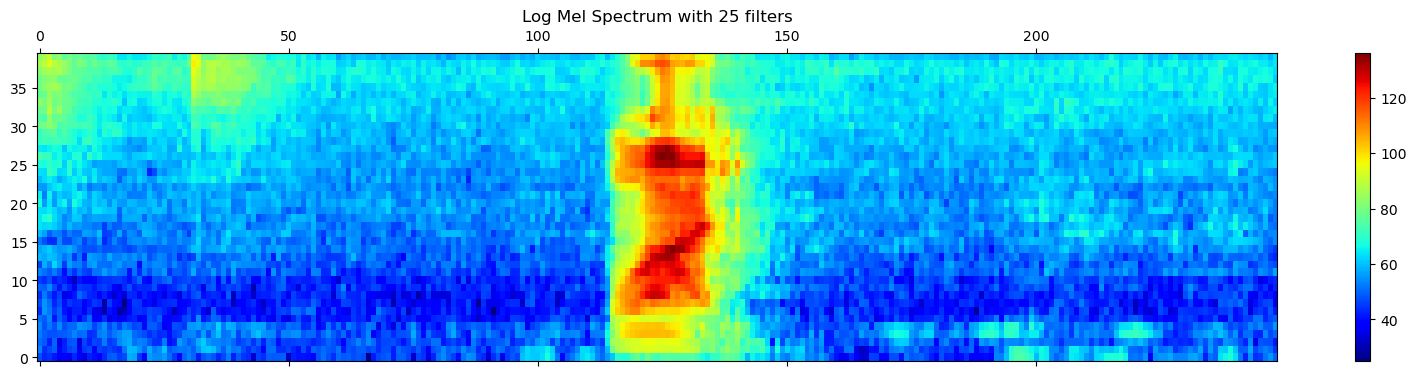

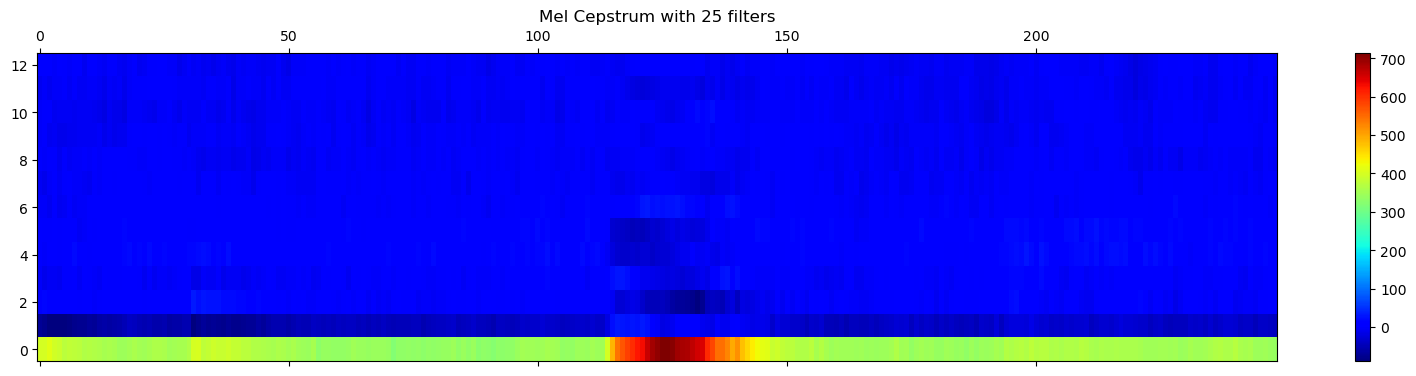

In [71]:
# Get two matrix from segments with 30 filters
log_mel_spectrum_matrix1,mel_cepstrum_matrix1=get_two_matrix(seg,30)
log_mel_spectrum_matrix1,mel_cepstrum_matrix1=np.array(log_mel_spectrum_matrix),np.array(mel_cepstrum_matrix)

# Plot Log Mel spectrum and Mel cepstrum
plot_show(log_mel_spectrum_matrix1.T,'Log Mel Spectrum with 30 filters')
plot_show(mel_cepstrum_matrix1.T, 'Mel Cepstrum with 30 filters')

# Get two matrix from segments with 25 filters
log_mel_spectrum_matrix2,mel_cepstrum_matrix2=get_two_matrix(seg,25)
log_mel_spectrum_matrix2,mel_cepstrum_matrix2=np.array(log_mel_spectrum_matrix),np.array(mel_cepstrum_matrix)

# Plot Log Mel spectrum and Mel cepstrum
plot_show(log_mel_spectrum_matrix2.T,'Log Mel Spectrum with 25 filters')
plot_show(mel_cepstrum_matrix2.T, 'Mel Cepstrum with 25 filters')

# 6. An example segment

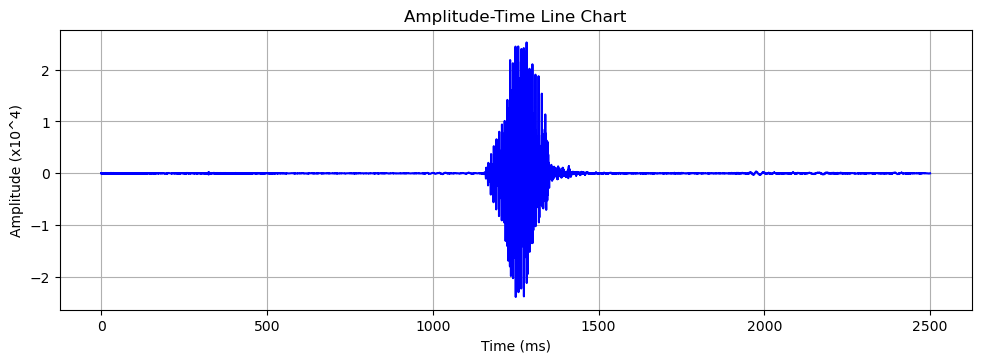

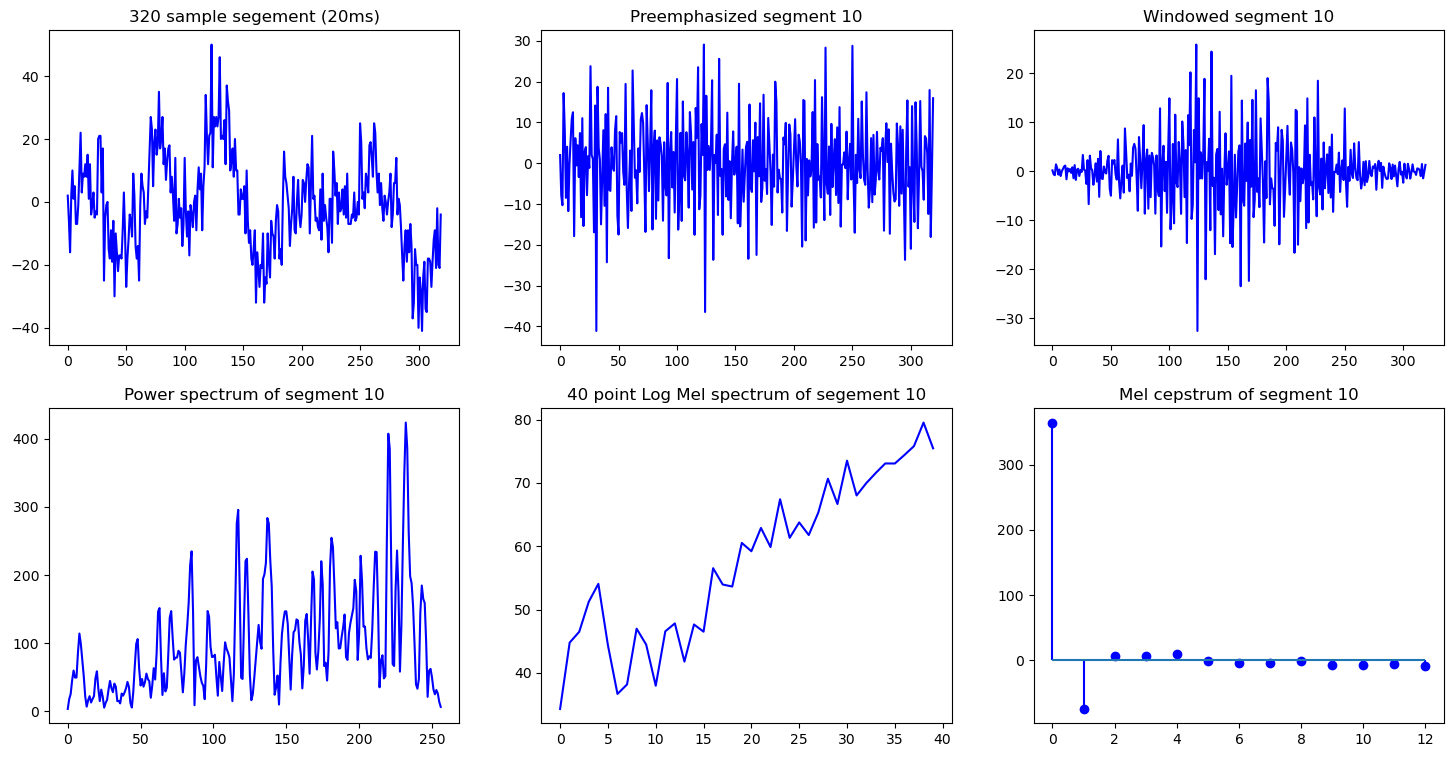

In [72]:
# Plot the amplitude-time line chart for the audio
plt.figure(figsize=(40, 8))
plt.subplot(231)
plt.plot(time*1000, signal/10000, color='blue')
plt.title('Amplitude-Time Line Chart')
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude (x10^4)')
plt.grid(True)
plt.show()
# Plot segment 10
plt.figure(figsize=(18, 9))
plt.subplot(231)
plt.plot([i for i in range(0,320)], seg[9], color='blue')
plt.title('320 sample segement (20ms)')

# Plot preemphasized segment 10
plt.subplot(232)
plt.plot([i for i in range(0,320)], Preemphasizing(seg[9]), color='blue')
plt.title('Preemphasized segment 10')

# Plot windowed segment 10
plt.subplot(233)
plt.plot([i for i in range(0,320)], windowing(Preemphasizing(seg[9])), color='blue')
plt.title('Windowed segment 10')

# Plot power spectrum of segment 10
plt.subplot(234)
plt.plot([i for i in range(0,257)], FFT(windowing(Preemphasizing(seg[9]))), color='blue')
plt.title('Power spectrum of segment 10')



# Plot 40 point Log Mel spectrum of segement 10
plt.subplot(235)
plt.plot([i for i in range(0,40)], log_mel_spectrum_matrix[9], color='blue')
plt.title('40 point Log Mel spectrum of segement 10')


# plot mel cepstrum of segment 10
plt.subplot(236)
plt.scatter([i for i in range(0, 13)], mel_cepstrum_matrix[9], color='blue')
plt.title('Mel cepstrum of segment 10')

for i, y_value in enumerate(mel_cepstrum_matrix[9]):
    plt.vlines(x=i, ymin=0, ymax=y_value, color='b')
plt.hlines(y=0,xmin=0,xmax=12)
plt.show()